In [1]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import xgboost as xgb
import numpy as np
from sklearn import tree

shap.initjs()

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


1. [Load Data](#Load-data)
2. [Train Model](#Train-model)
3. [SHAP evaluation](#SHAP-evaluation)

## Load data

In [2]:
caseType = 2
txtSubname = "T01_A20B100C20Int50R0"#"T01_A20B5C20Int50R1"#'contiPositiveAge'# testP10N3comb2
oldData = pd.read_csv('./data/oldData{}.csv'.format(txtSubname)).iloc[:, 1:]
youngData = pd.read_csv('./data/youngData{}.csv'.format(txtSubname)).iloc[:, 1:]
totalData = pd.read_csv('./data/totalData{}.csv'.format(txtSubname)).iloc[:, 1:]
coef = np.loadtxt('./data/coef{}.txt'.format(txtSubname))
B_sex, B_trt, B_age, B_int = coef[0], coef[1], coef[2], coef[3]
print(B_sex, B_trt, B_age, B_int)
totalData

20.0 100.0 20.0 50.0


,T,Age,AgeTag,Sex,yo1,yo1CF,y1,y1CF,yo2,yo2CF,y2,y2CF,yo3,yo3CF,y3,y3CF
0,0.0,0.74,1.0,1.0,20.0,170.0,20.0,170.0,71.8,171.8,71.8,171.8,34.8,171.8,34.8,171.8
1,0.0,0.04,-1.0,1.0,20.0,170.0,20.0,170.0,22.8,122.8,22.8,122.8,20.8,122.8,20.8,122.8
2,1.0,0.18,-1.0,1.0,170.0,20.0,170.0,20.0,132.6,32.6,132.6,32.6,132.6,23.6,132.6,23.6
3,0.0,0.54,1.0,1.0,20.0,170.0,20.0,170.0,57.8,157.8,57.8,157.8,30.8,157.8,30.8,157.8
4,1.0,0.26,-1.0,0.0,100.0,0.0,100.0,0.0,105.2,5.2,105.2,5.2,118.2,5.2,118.2,5.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.52,1.0,1.0,20.0,170.0,20.0,170.0,56.4,156.4,56.4,156.4,30.4,156.4,30.4,156.4
996,1.0,0.50,-1.0,0.0,100.0,0.0,100.0,0.0,110.0,10.0,110.0,10.0,135.0,10.0,135.0,10.0
997,0.0,0.78,1.0,1.0,20.0,170.0,20.0,170.0,74.6,174.6,74.6,174.6,35.6,174.6,35.6,174.6
998,0.0,0.20,-1.0,1.0,20.0,170.0,20.0,170.0,34.0,134.0,34.0,134.0,24.0,134.0,24.0,134.0


In [3]:
def normalize(factual, cfactual, oriFactual, oriCFactual):
    """make y output normalization from 0 to 1"""
    globalMin = np.min(pd.concat((oriFactual, oriCFactual)))
    globalMax = np.max(pd.concat((oriFactual, oriCFactual)))
    
    return (factual - globalMin) / (globalMax - globalMin), (cfactual - globalMin) / (globalMax - globalMin)

In [4]:
for i in range(1, 4):
    totalData["y{}".format(i)], totalData["y{}CF".format(i)] = normalize(totalData["y{}".format(i)], totalData["y{}CF".format(i)], totalData["yo{}".format(i)], totalData["yo{}CF".format(i)])
    totalData["yo{}".format(i)], totalData["yo{}CF".format(i)] = normalize(totalData["yo{}".format(i)], totalData["yo{}CF".format(i)], totalData["yo{}".format(i)], totalData["yo{}CF".format(i)])

In [5]:
totalData

,T,Age,AgeTag,Sex,yo1,yo1CF,y1,y1CF,yo2,yo2CF,y2,y2CF,yo3,yo3CF,y3,y3CF
0,0.0,0.74,1.0,1.0,0.117647,1.000000,0.117647,1.000000,0.376582,0.904008,0.376582,0.904008,0.181435,0.904008,0.181435,0.904008
1,0.0,0.04,-1.0,1.0,0.117647,1.000000,0.117647,1.000000,0.118143,0.645570,0.118143,0.645570,0.107595,0.645570,0.107595,0.645570
2,1.0,0.18,-1.0,1.0,1.000000,0.117647,1.000000,0.117647,0.697257,0.169831,0.697257,0.169831,0.697257,0.122363,0.697257,0.122363
3,0.0,0.54,1.0,1.0,0.117647,1.000000,0.117647,1.000000,0.302743,0.830169,0.302743,0.830169,0.160338,0.830169,0.160338,0.830169
4,1.0,0.26,-1.0,0.0,0.588235,0.000000,0.588235,0.000000,0.552743,0.025316,0.552743,0.025316,0.621308,0.025316,0.621308,0.025316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.52,1.0,1.0,0.117647,1.000000,0.117647,1.000000,0.295359,0.822785,0.295359,0.822785,0.158228,0.822785,0.158228,0.822785
996,1.0,0.50,-1.0,0.0,0.588235,0.000000,0.588235,0.000000,0.578059,0.050633,0.578059,0.050633,0.709916,0.050633,0.709916,0.050633
997,0.0,0.78,1.0,1.0,0.117647,1.000000,0.117647,1.000000,0.391350,0.918776,0.391350,0.918776,0.185654,0.918776,0.185654,0.918776
998,0.0,0.20,-1.0,1.0,0.117647,1.000000,0.117647,1.000000,0.177215,0.704641,0.177215,0.704641,0.124473,0.704641,0.124473,0.704641


In [6]:
X = totalData[["T", "Age", "Sex"]]
y = totalData["y"+str(caseType)]

## Train model

In [7]:
#Train model
model = xgb.XGBRegressor(objective="reg:squarederror",max_depth=3)
model.fit(X, y)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:>

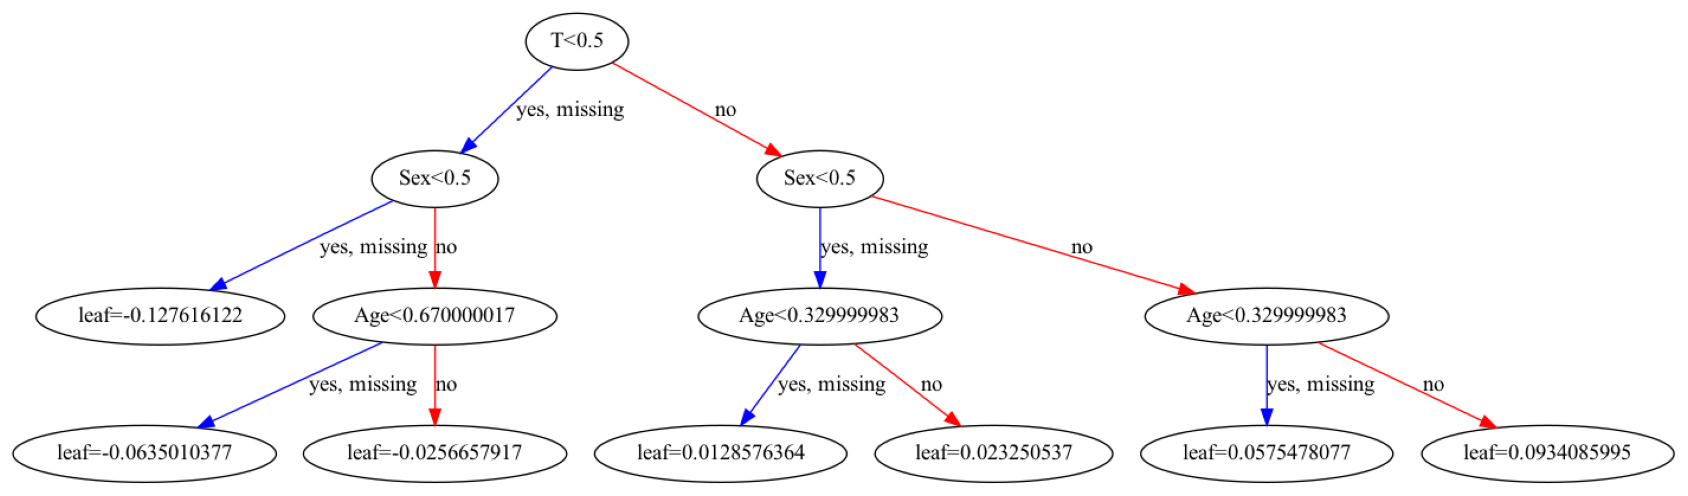

In [8]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(model, ax=ax)

## SHAP evaluation

In [9]:
explainer = shap.TreeExplainer(model)
shap_interaction = explainer.shap_interaction_values(X, tree_limit=-1)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [10]:
#Get model predictions
y_pred = model.predict(X)

#Calculate mean prediction 
mean_pred = np.mean(y_pred)

#Sum of interaction values for first employee
sum_shap = np.sum(shap_interaction[0])

#Values below should be the same
print("Model prediction: {}".format(y_pred[0]))
print("Mean prediction + interaction values: {}".format(mean_pred+sum_shap))

Model prediction: 0.3750850558280945
Mean prediction + interaction values: 0.3750849962234497


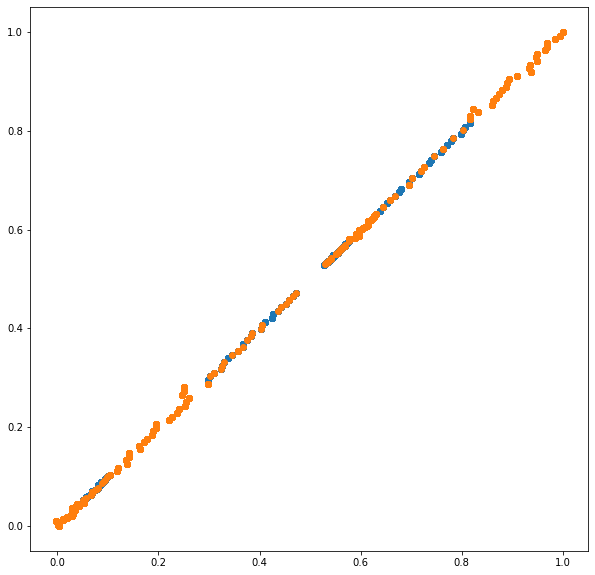

In [11]:
y_pred = model.predict(X)
cfX = X.copy()
cfX.iloc[:, 0] = 1 - cfX.iloc[:, 0]
ycf_pred = model.predict(cfX)
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.scatter(y_pred, y)
axs.scatter(ycf_pred, totalData["y{}CF".format(caseType)])


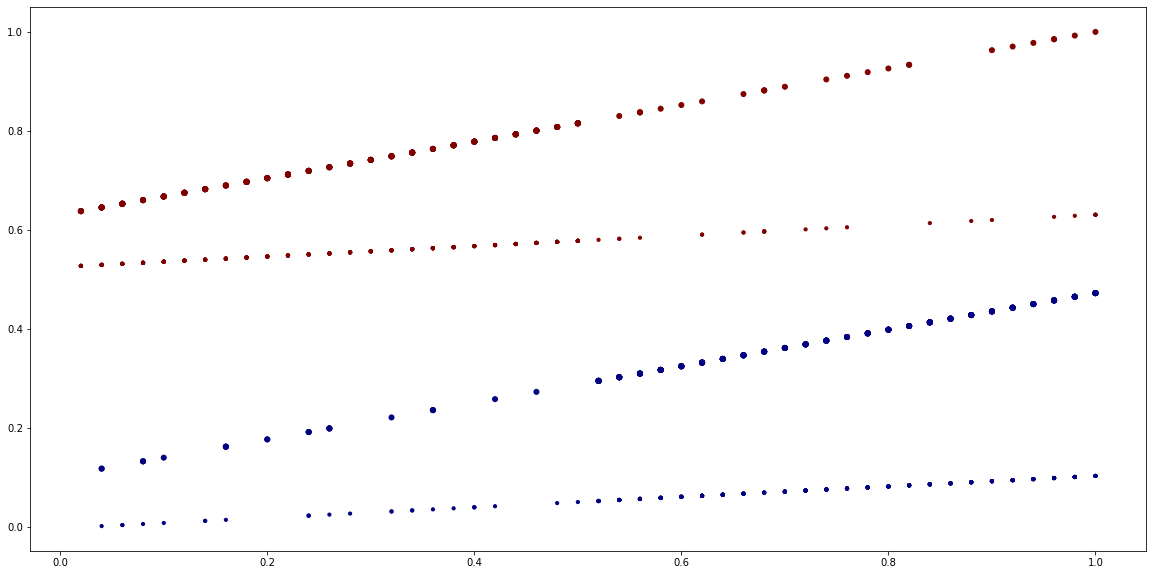

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.scatter(totalData["Age"], y, c=totalData["T"], s=totalData["Sex"]*15+10, cmap="jet")

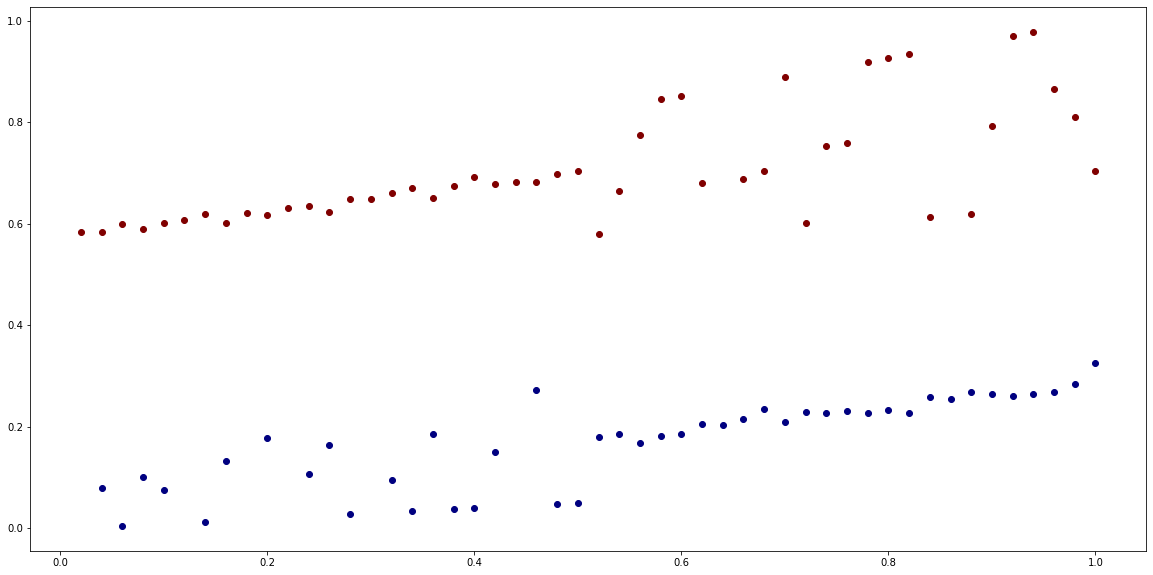

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
for ageVal in np.unique(totalData["Age"]):
    axs.scatter(ageVal, np.mean(y[np.logical_and(totalData["Age"]==ageVal, totalData["T"] == 1)]), c=1, cmap="jet", vmin=0, vmax=1)#, s=totalData["Sex"]*15+10)
    axs.scatter(ageVal, np.mean(y[np.logical_and(totalData["Age"]==ageVal, totalData["T"] == 0)]), c=0, cmap="jet", vmin=0, vmax=1)#, s=totalData["Sex"]*15+10)
    

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'T'), Text(0, 1.5, 'Age'), Text(0, 2.5, 'Sex')])

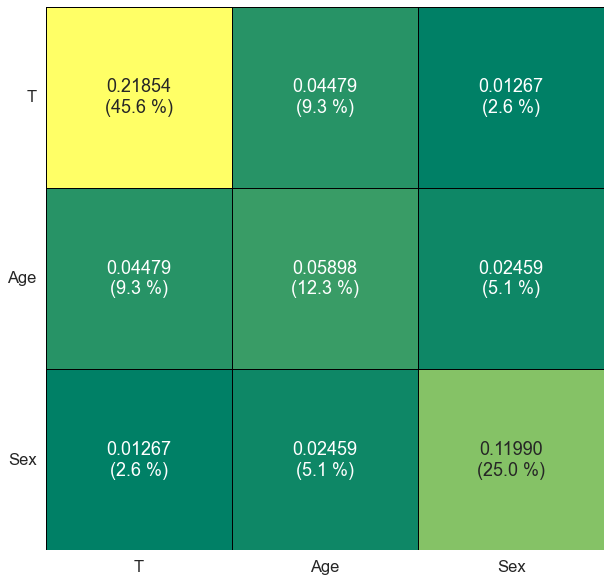

In [14]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)
totalSum = 0
for i in range(mean_shap.shape[0]):
    for j in range(mean_shap.shape[1]):
        if i <= j:
            totalSum += mean_shap[i, j]

label = []
for i in range(mean_shap.shape[0]):
    for j in range(mean_shap.shape[1]):
        label.append("{:.5f}\n({:.1f} %)".format(mean_shap[i, j], mean_shap[i, j]/totalSum*100))
label = np.array(label).reshape(mean_shap.shape)
# display 
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(df,cmap='summer',annot=label, fmt="",cbar=False,linewidths=1, linecolor='black')
plt.yticks(rotation=0) 

In [ ]:
plt.scatter(shap_interaction[:, 0, 1] * 2, np.full(shape=X["T"].shape, fill_value=0))
plt.scatter(shap_interaction[:, 1, 2] * 2, np.full(shape=X["T"].shape, fill_value=1))
plt.scatter(shap_interaction[:, 2, 0] * 2, np.full(shape=X["T"].shape, fill_value=2))
plt.scatter(shap_interaction[:, 0, 0], np.full(shape=X["T"].shape, fill_value=3))
plt.scatter(shap_interaction[:, 1, 1], np.full(shape=X["T"].shape, fill_value=4))
plt.scatter(shap_interaction[:, 2, 2], np.full(shape=X["T"].shape, fill_value=5))
plt.yticks([0, 1, 2, 3, 4, 5], ["Age * T", "Sex * Age", "Sex * T", "T", "Age", "Sex"])
plt.show()

In [ ]:
explainer.expected_value
a = (np.mean(y[np.logical_and(X["Age"] < 0.5, X["T"] == 1)]))
b = (np.mean(y[np.logical_and(X["Age"] < 0.5, X["T"] == 0)]))
c = (np.mean(y[np.logical_and(X["Age"] > 0.5, X["T"] == 1)]))
d = (np.mean(y[np.logical_and(X["Age"] > 0.5, X["T"] == 0)]))
print(a, b, a-b)
print(c, d, c-d)

In [ ]:
plt.scatter(X["Age"], shap_interaction[:, 1, 0]* 2, c=X["T"], cmap="jet")
#plt.scatter(X["Age"], totalData["yo{}".format(caseType)], c=X["T"])#shap_interaction[:, 1, 0]* 2)
#plt.scatter([0, 0, 1, 1], [a, b, c, d], c=[1, 0, 1, 0])
plt.colorbar()

In [ ]:
plt.scatter(X["Age"], totalData["yo{}".format(caseType)], c=X["T"])#shap_interaction[:, 1, 0]* 2)
plt.scatter([0, 0, 1, 1], [a, b, c, d], c=[1, 0, 1, 0])
plt.colorbar()

In [ ]:
plt.scatter(X["Age"], shap_interaction[:, 1, 2]* 2, c=X["Sex"])
plt.colorbar()

## Evaluation

In [ ]:
# Copy from https://github.com/AMLab-Amsterdam/CEVAE/evaluation.py
class Evaluator(object):
    def __init__(self, y, t, y_cf=None, mu0=None, mu1=None):
        self.y = y
        self.t = t
        self.y_cf = y_cf
        self.mu0 = mu0
        self.mu1 = mu1
        if mu0 is not None and mu1 is not None:
            self.true_ite = mu1 - mu0

    def rmse(self, yPred, yPredCF):
        F = np.sqrt(np.mean((self.y - yPred) ** 2))
        CF = np.sqrt(np.mean((self.y_cf - yPredCF) ** 2))
        total = np.sqrt(np.mean((self.y - yPred) ** 2) + np.mean(self.y_cf - yPredCF) ** 2)
        return F, CF, total
    
    def rmse_ite(self, ypred1, ypred0):
        pred_ite = np.zeros_like(self.true_ite)
        idx1, idx0 = np.where(self.t == 1), np.where(self.t == 0)
        ite1, ite0 = self.y[idx1] - ypred0[idx1], ypred1[idx0] - self.y[idx0]
        pred_ite[idx1] = ite1
        pred_ite[idx0] = ite0
        return np.sqrt(np.mean(np.square(self.true_ite - pred_ite)))

    def abs_ate(self, ypred1, ypred0):
        return np.abs(np.mean(ypred1 - ypred0) - np.mean(self.true_ite))

    def pehe(self, ypred1, ypred0):
        return np.sqrt(np.mean(np.square((self.mu1 - self.mu0) - (ypred1 - ypred0))))

    def getPredITE(self, ypred1, ypred0):
        pred_ite = np.zeros_like(self.true_ite)
        idx1, idx0 = np.where(self.t == 1), np.where(self.t == 0)
        ite1, ite0 = self.y[idx1] - ypred0[idx1], ypred1[idx0] - self.y[idx0]
        pred_ite[idx1] = ite1
        pred_ite[idx0] = ite0
        return pred_ite

In [ ]:
xt0 = X.copy()
xt0["T"] = 0
xt1 = X.copy()
xt1["T"] = 1
ypred0 = model.predict(xt0)
ypred1 = model.predict(xt1)

data = totalData
mu1, mu0 = np.zeros(ypred0.shape), np.zeros(ypred0.shape)
mu1[X["T"] == 1] = data["yo{}".format(caseType)][X["T"] == 1]
mu1[X["T"] == 0] = data["yo{}CF".format(caseType)][X["T"] == 0]
mu0[X["T"] == 0] = data["yo{}".format(caseType)][X["T"] == 0]
mu0[X["T"] == 1] = data["yo{}CF".format(caseType)][X["T"] == 1]

eva = Evaluator(y=np.array(data["y{}".format(caseType)]), 
                t=np.array(data["T"]), 
                y_cf=np.array(data["y{}CF".format(caseType)]), 
                mu0=mu0, 
                mu1=mu1)

print("Entire")
print("RMSE: {}".format(eva.rmse(yPred=y_pred, yPredCF=ycf_pred)))
print("ITE : {}".format(eva.rmse_ite(ypred1=ypred1, ypred0=ypred0)))
print("ATE : {}".format(eva.abs_ate(ypred1=ypred1, ypred0=ypred0)))
print("PEHE: {}".format(eva.pehe(ypred1=ypred1, ypred0=ypred0)))

In [ ]:
plt.scatter(ypred0, mu0)
plt.scatter(ypred1, mu1)
plt.plot([0, 1], [0, 1], color='black')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.scatter((mu1 - mu0), eva.getPredITE(ypred1=ypred1, ypred0=ypred0))
axs.scatter(mu1-mu0, mu1-mu0)
#plt.xlim(0.2, 0.3)
#plt.ylim(0.2, 0.3)
plt.suptitle("ITE")

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.scatter((mu1 - mu0), (ypred1 - ypred0))
axs.scatter(mu1-mu0, mu1-mu0)
#plt.xlim(0.2, 0.3)
#plt.ylim(0.2, 0.3)
plt.suptitle("ATE / PEHE")

In [ ]:
threshold = 0.50

In [ ]:
dataSmall = data[data["Age"] <= threshold]
dataSmall

y = dataSmall["y"+str(caseType)]

Xsmall = dataSmall['T']
Xsmall = pd.concat((Xsmall, dataSmall.iloc[:, 1], dataSmall.iloc[:, 3]), axis=1)
arrXsmall = np.array(Xsmall)
ySmall = dataSmall['y{}'.format(caseType)]
yCFsmall = dataSmall['y{}CF'.format(caseType)]

modelSmall = xgb.XGBRegressor(objective="reg:squarederror",max_depth=2)
modelSmall.fit(arrXsmall, ySmall)
y_predSmall = modelSmall.predict(arrXsmall)
cfXsmall = Xsmall.copy()
cfXsmall.iloc[:, 0] = 1 - cfXsmall.iloc[:, 0]
ycf_predSmall = modelSmall.predict(np.array(cfXsmall))

In [ ]:
xt0 = Xsmall.copy()
xt0["T"] = 0
xt1 = Xsmall.copy()
xt1["T"] = 1
ypred0small = modelSmall.predict(np.array(xt0))
ypred1small = modelSmall.predict(np.array(xt1))


mu1small, mu0small = np.zeros(ypred0small.shape), np.zeros(ypred0small.shape)
mu1small[Xsmall["T"] == 1]  = dataSmall["yo{}".format(caseType)][Xsmall["T"] == 1]
mu1small[Xsmall["T"] == 0] = dataSmall["yo{}CF".format(caseType)][Xsmall["T"] == 0]
mu0small[Xsmall["T"] == 0] = dataSmall["yo{}".format(caseType)][Xsmall["T"] == 0]
mu0small[Xsmall["T"] == 1]  = dataSmall["yo{}CF".format(caseType)][Xsmall["T"] == 1]

evaSmall = Evaluator(y=np.array(dataSmall["y{}".format(caseType)]), 
                t=np.array(dataSmall["T"]), 
                y_cf=np.array(dataSmall["y{}CF".format(caseType)]), 
                mu0=mu0small, 
                mu1=mu1small)

print("Small")
print("RMSE:{}".format(evaSmall.rmse(y_predSmall, ycf_predSmall)))
print("ITE: {}".format(evaSmall.rmse_ite(ypred1=ypred1small, ypred0=ypred0small)))
print("ATE : {}".format(evaSmall.abs_ate(ypred1=ypred1small, ypred0=ypred0small)))
print("PEHE: {}".format(evaSmall.pehe(ypred1=ypred1small, ypred0=ypred0small)))

In [ ]:
plt.scatter(ypred0small, mu0small)
plt.scatter(ypred1small, mu1small)
#plt.plot([-100, 200], [-100, 200])

In [ ]:
dataLarge = data[data["Age"] > threshold]
dataLarge

y = dataLarge["y"+str(caseType)]

Xlarge = dataLarge['T']
Xlarge = pd.concat((Xlarge, dataLarge.iloc[:, 1], dataLarge.iloc[:, 3]), axis=1)
arrXlarge = np.array(Xlarge)
yLarge = dataLarge['y{}'.format(caseType)]
yCFlarge = dataLarge['y{}CF'.format(caseType)]

modelLarge = xgb.XGBRegressor(objective="reg:squarederror",max_depth=2)
modelLarge.fit(arrXlarge, yLarge)
y_predLarge = modelLarge.predict(arrXlarge)
cfXlarge = Xlarge.copy()
cfXlarge.iloc[:, 0] = 1 - cfXlarge.iloc[:, 0]
ycf_predLarge = modelLarge.predict(np.array(cfXlarge))

In [ ]:
xt0 = Xlarge.copy()
xt0["T"] = 0
xt1 = Xlarge.copy()
xt1["T"] = 1
ypred0large = modelLarge.predict(np.array(xt0))
ypred1large = modelLarge.predict(np.array(xt1))


mu1large, mu0large = np.zeros(ypred0large.shape), np.zeros(ypred0large.shape)
mu1large[Xlarge["T"] == 1] = dataLarge["yo{}".format(caseType)][Xlarge["T"] == 1]
mu1large[Xlarge["T"] == 0] = dataLarge["yo{}CF".format(caseType)][Xlarge["T"] == 0]
mu0large[Xlarge["T"] == 0] = dataLarge["yo{}".format(caseType)][Xlarge["T"] == 0]
mu0large[Xlarge["T"] == 1] = dataLarge["yo{}CF".format(caseType)][Xlarge["T"] == 1]

evaLarge = Evaluator(y=np.array(dataLarge["y{}".format(caseType)]), 
                t=np.array(dataLarge["T"]), 
                y_cf=np.array(dataLarge["y{}CF".format(caseType)]), 
                mu0=mu0large, 
                mu1=mu1large)

print("Large")
print("RMSE: {}".format(evaLarge.rmse(y_predLarge, ycf_predLarge)))
print("ITE : {}".format(evaLarge.rmse_ite(ypred1=ypred1large, ypred0=ypred0large)))
print("ATE : {}".format(evaLarge.abs_ate(ypred1=ypred1large, ypred0=ypred0large)))
print("PEHE: {}".format(evaLarge.pehe(ypred1=ypred1large, ypred0=ypred0large)))

In [ ]:
plt.scatter(ypred0large, mu0large)
plt.scatter(ypred1large, mu1large)
#plt.plot([-100, 200], [-100, 200])